In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import OrderedDict
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

from npiv import iv_simulator, custom_objectives, model_wrapper, NonparametricIV

In [2]:
# 0. random data.  price is endogenous, instrument is this 
n = 60000 # number of observations
d = 2 # dimensionality of the exogenous regressors in x
    
ivsim = iv_simulator.IVSimulator(num_exog_x_cols=d, numpy_random_seed=0)
df = ivsim.generate_data(num_obs=n)
df['id'] = np.arange(n)

test_cutoff = 50000
df_train = df.iloc[:test_cutoff,:]
df_test = df.iloc[test_cutoff:,:]

# Helper functions

In [3]:
#  we'll be doing some experiments where we use the true quantiles to test
#  just the second stage of the NonparmatricIV process, an in order to do that
#  we'll need a class for producing true quantiles in this synthetic example
class TrueQtlModel:
    elast_max = ivsim.elast_max
    elast_min = ivsim.elast_min
    log_cost_coefs = ivsim.log_cost_coefs
    exog_x_cols = ivsim.exog_x_cols
    instrument_col = ivsim.instrument_col
    def __init__(self, alpha):
        self.alpha=alpha
    def feature_name(self):
        return self.exog_x_cols+[self.instrument_col]
    def predict(self, df):
        elast_qtl = self.alpha * (self.elast_max - self.elast_min) + self.elast_min 
        log_costs = iv_simulator.generate_log_costs(df[self.exog_x_cols], self.log_cost_coefs)
        log_price_qtl = iv_simulator.generate_log_optimal_prices(log_costs, elast_qtl) + df[self.instrument_col]
        return log_price_qtl

In [4]:
def plot_performance_and_implied_margin_effects_vs_iteration(model, df_test, metric_name = 'grouped sse', 
                                                             num_grid_pts=50):
    '''
    function to compute and plot the distribution of marginal effects of a model,
        with respect to each of the model features, at the various points defined
        by df_tests    
    model should be some NonparametricIv.stage2_model when trained with 'lgb' option
    df_test should be some hold-out data
    '''
    eval_results = model.eval_results['val'][metric_name]
    num_iters = len(eval_results)
    # generate time series of marginal effects
    dfs_to_concat = []
    for num_iteration in np.linspace(1,num_iters, num_grid_pts, dtype=int):
        print(num_iteration, end=" ")
        mfx = model.marginal_effect_plots(df_test, plot=False, predict_kwargs={'num_iteration':num_iteration})
        tmp_df = mfx.groupby('feature name').describe().transpose().reset_index(level=0,drop=True)\
                    .reset_index().rename(columns={'index':'stat'})
        tmp_df.columns.name=None
        tmp_df['num_iteration'] = num_iteration
        tmp_df.set_index(['num_iteration', 'stat'], inplace=True)
        dfs_to_concat.append(tmp_df)
    desc_df = pd.concat(dfs_to_concat)
    fig, axes = plt.subplots(nrows=desc_df.shape[1]+1, ncols=1, figsize=(10, (desc_df.shape[1]+1)*1.5), sharex=True)
    # plot performance
    ax = axes[0]
    ax.grid()
    best_num_trees = np.argmin(eval_results)
    best_perf, final_perf = eval_results[best_num_trees], eval_results[-1]
    ax.plot(eval_results)
    ax.axvline(best_num_trees, color='blue', linewidth=1)
    ax.set_yscale('log')
    ax.set_title("validation set performance, blue=best={:.3E}, final={:.3E}".format(best_perf, final_perf))
    # plot marginal effects
    for i,c in enumerate(desc_df.columns):
        tmp_df = desc_df.loc[pd.IndexSlice[:, ['mean', 'min', 'max', '25%', '75%']],c].unstack()
        ax = axes[i+1]
        ax.grid()
        # plot the true marginal effects
        if c=='log_price_synthetic':
            true_mfx = ivsim.log_sales_coefs.loc['log_price']
        else:
            true_mfx = ivsim.log_sales_coefs.loc[c]
        ax.axhline(true_mfx, color='red', linewidth=1)
        ax.axvline(best_num_trees, color='blue', linewidth=1)
        # plot the model implied marignal effects
        ax.plot(tmp_df['mean'], color='black', linestyle='-')
        ax.plot(tmp_df['25%'], color='black', linestyle='-.')
        ax.plot(tmp_df['75%'], color='black', linestyle='-.')
        ax.set_title('mean and quartiles of marginal effects of `{}`, red = truth'.format(c))
    plt.xlabel("number of trees trained")
    plt.tight_layout()

# I. various stage-2 objectives, assuming we have access to true quantiles

## I.0 define the true stage1 quantile-generating functions

In [5]:
# now, we can construct the dict models for passing into NonparametricIV
# use the same quantiles as the model where we estimate stage1
num_qtls = 10
qtl_list = np.arange(0 , 1 , 1/num_qtls) + (1/num_qtls/2)
print(qtl_list)
stage1_models = {alpha : TrueQtlModel(alpha) for alpha in qtl_list}

[ 0.05  0.15  0.25  0.35  0.45  0.55  0.65  0.75  0.85  0.95]


## I.1. define NPIV models, with various stage2 models/objectives


In [6]:
# linear model, upper-bound objective
npiv_lin_upper = NonparametricIV(df=df_train,
                                 exog_x_cols=ivsim.exog_x_cols, 
                                 instrument_cols = ['instrument'],
                                 endog_x_col=ivsim.endog_x_col,
                                 y_col=ivsim.y_col,
                                 stage1_models=stage1_models,
                                 id_col='id',
                                 stage2_model_type='linear',
                                 stage2_objective='upper')

In [7]:
# linear model, true objective
npiv_lin_true = NonparametricIV(df=df_train,
                                 exog_x_cols=ivsim.exog_x_cols, 
                                 instrument_cols = ['instrument'],
                                 endog_x_col=ivsim.endog_x_col,
                                 y_col=ivsim.y_col,
                                 stage1_models=stage1_models,
                                 id_col='id',
                                 stage2_model_type='linear',
                                 stage2_objective='true')

In [8]:
# LGB model, upper-bound objective
npiv_lgb_upper = NonparametricIV(df=df_train,
                                 exog_x_cols=ivsim.exog_x_cols, 
                                 instrument_cols = ['instrument'],
                                 endog_x_col=ivsim.endog_x_col,
                                 y_col=ivsim.y_col,
                                 stage1_models=stage1_models,
                                 id_col='id',
                                 stage2_model_type='lgb',
                                 stage2_objective='upper')

In [9]:
# LGB model, true objective
npiv_lgb_true = NonparametricIV(df=df_train,
                                 exog_x_cols=ivsim.exog_x_cols, 
                                 instrument_cols = ['instrument'],
                                 endog_x_col=ivsim.endog_x_col,
                                 y_col=ivsim.y_col,
                                 stage1_models=stage1_models,
                                 id_col='id',
                                 stage2_model_type='lgb',
                                 stage2_objective='true')

## I.2. compute second-stage coefs via 2sls as baseline
- our setup is linear in both the first and second stage
- so 2SLS should correctly estimate the coefficients
- and they do

In [10]:
%%time
df = npiv_lgb_true.data
df = df.loc[df['_purpose_']=='train2'].copy()
print(df.shape)
# stage1
from sklearn.linear_model import LinearRegression
model1 = LinearRegression()
xcols1, ycol1 = ['x_0', 'x_1', 'instrument'], 'log_price'
model1.fit(df[xcols1], df[ycol1])
print(model1.coef_)
# stage2
df['pred_log_price'] = model1.predict(df[xcols1])
model2 = LinearRegression()
xcols2, ycol2 = ['x_0', 'x_1', 'pred_log_price'], 'log_sales'
model2.fit(df[xcols2], df[ycol2])
# print coefs of stage2 vs the truth
stage2_coef_vs_true = pd.DataFrame({'true':ivsim.log_sales_coefs, '2sls':model2.coef_})
display(stage2_coef_vs_true)

(20000, 7)
[ 0.70598194  0.70660759  1.0313948 ]


,true,2sls
x_0,0.707107,0.698864
x_1,0.707107,0.658847
log_price,-4.000000,-3.971273


CPU times: user 72 ms, sys: 109 ms, total: 181 ms
Wall time: 33 ms


## I.3. estimate stage2 for these models, using the true stage1 quantile functions

### I.3.a.  Linear Regression, upper bound objective
- estimated coefficients don't match true one
- e.g. coefficient on log_price is -4, but the estiamte is close to 0

In [11]:
%%time
npiv_lin_upper.train_stage2(force=True)
model = npiv_lin_upper.stage2_model
coef_df = pd.DataFrame({'estimated coefficients':model.coef_}, index=model.feature_name()).sort_index()
display(coef_df)

,estimated coefficients
log_price,-0.164565
x_0,-1.988656
x_1,-2.019193


CPU times: user 161 ms, sys: 247 ms, total: 408 ms
Wall time: 115 ms


### I.3.b. Linear Regression, true objective
- estimate marginal effects are close to truth

In [12]:
%%time
npiv_lin_true.train_stage2(force=True)
model = npiv_lin_true.stage2_model
coef_df = pd.DataFrame({'estimated coefficients':model.coef_}, index=model.feature_name()).sort_index()
display(coef_df)

,estimated coefficients
log_price,-4.166086
x_0,0.839376
x_1,0.806916


CPU times: user 3.36 s, sys: 86.5 ms, total: 3.44 s
Wall time: 2.6 s


### I.3.c. LGB, upper bound objective
- estimated marginal effects don't appear to approach true ones
- e.g. the true effect of log_price is -4, but the estiamted marginal effects are close to 0

In [13]:
%%time
npiv_lgb_upper.train_stage2(force=True)
model = npiv_lgb_upper.stage2_model

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1000]	train's l2: 3.64331	val's l2: 3.70104
[2000]	train's l2: 3.62046	val's l2: 3.72497
[3000]	train's l2: 3.61848	val's l2: 3.7331
[4000]	train's l2: 3.61745	val's l2: 3.73478
[5000]	train's l2: 3.61687	val's l2: 3.74149
[6000]	train's l2: 3.61661	val's l2: 3.73932
[7000]	train's l2: 3.61641	val's l2: 3.7433
[8000]	train's l2: 3.61621	val's l2: 3.74165
[9000]	train's l2: 3.6162	val's l2: 3.74251
[10000]	train's l2: 3.61613	val's l2: 3.74362
CPU times: user 3min, sys: 397 ms, total: 3min
Wall time: 45.3 s


marginal effect                                           \
                        mean       std        min       25%       50%   
feature name                                                            
log_price          -0.174737  0.469126  -2.748471 -0.413173 -0.165587   
x_0                -1.990971  1.594930  -7.571464 -2.991891 -2.004502   
x_1                -2.030018  1.633040 -10.189970 -2.951821 -1.937469   

                                  
                   75%       max  
feature name                      
log_price     0.048737  4.038548  
x_0          -0.928390  5.817291  
x_1          -1.133202  4.028137

1 205 409 613 817 1021 1225 1429 1633 1837 2041 2245 2449 2653 2857 3061 3265 3470 3674 3878 4082 4286 4490 4694 4898 5102 5306 5510 5714 5918 6122 6326 6530 6735 6939 7143 7347 7551 7755 7959 8163 8367 8571 8775 8979 9183 9387 9591 9795 10000 CPU times: user 22min 2s, sys: 518 ms, total: 22min 3s
Wall time: 5min 32s


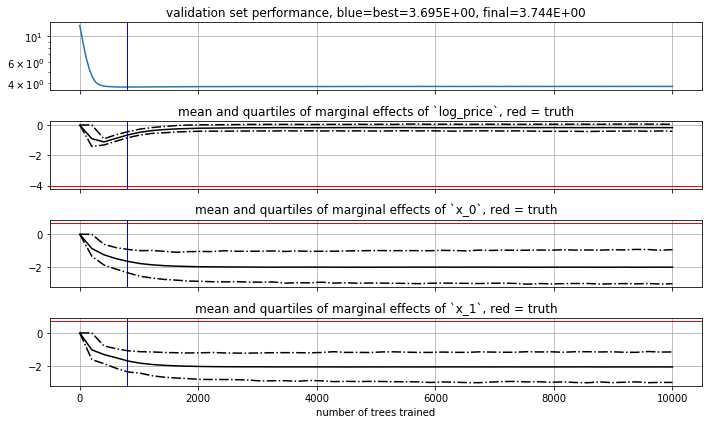

In [14]:
%%time
# print some marginal effects implied by the model
marginal_fx = model.marginal_effect_plots(df_test, plot=False)
display(marginal_fx.groupby('feature name').describe().drop(('marginal effect', 'count'), axis=1))
# and plot it
plot_performance_and_implied_margin_effects_vs_iteration(model, df_test, metric_name='l2', num_grid_pts=50)

### I.3.d LGB, true objective
- appears to work
- but still shrunk a bit towards 0 relative to the truth, or the linear true objective
- as we train many trees, implied marginal effects begin to be clustered around the truth
- however, variance is quite high, and estimates can be quite far from the truth 
    - e.g. estimated marginal effects for log_price has a std of 5.26, which is fairly large compared to the true value of -4
- furthermore, if we were to use the validation set for early stopping, then the implied marginal effects up to that point would be quite biased
- though it doesn't seem like training for longer beyond the optimal early stopping time does much to degrade performance

In [15]:
%%time
npiv_lgb_true.train_stage2(force=True)
model = npiv_lgb_true.stage2_model

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1000]	train's grouped sse: 7.14494e+06	val's grouped sse: 1.83776e+06
[2000]	train's grouped sse: 7.09537e+06	val's grouped sse: 1.84625e+06
[3000]	train's grouped sse: 7.08135e+06	val's grouped sse: 1.84801e+06
[4000]	train's grouped sse: 7.07302e+06	val's grouped sse: 1.84701e+06
[5000]	train's grouped sse: 7.06901e+06	val's grouped sse: 1.84897e+06
[6000]	train's grouped sse: 7.06563e+06	val's grouped sse: 1.84922e+06
[7000]	train's grouped sse: 7.06324e+06	val's grouped sse: 1.85094e+06
[8000]	train's grouped sse: 7.06168e+06	val's grouped sse: 1.84874e+06
[9000]	train's grouped sse: 7.06081e+06	val's grouped sse: 1.85094e+06
[10000]	train's grouped sse: 7.05995e+06	val's grouped sse: 1.85149e+06
CPU times: user 27min 40s, sys: 5.78 s, total: 27min 46s
Wall time: 9min 4s


marginal effect                                           \
                        mean       std        min       25%       50%   
feature name                                                            
log_price          -3.586832  5.258241 -32.922922 -6.805069 -3.545278   
x_0                 0.424122  1.585786  -4.138906 -0.567084  0.333516   
x_1                 0.394976  1.618738  -7.252256 -0.539877  0.448157   

                                   
                   75%        max  
feature name                       
log_price    -0.256272  21.919914  
x_0           1.450695   6.354371  
x_1           1.392769   7.198778

1 205 409 613 817 1021 1225 1429 1633 1837 2041 2245 2449 2653 2857 3061 3265 3470 3674 3878 4082 4286 4490 4694 4898 5102 5306 5510 5714 5918 6122 6326 6530 6735 6939 7143 7347 7551 7755 7959 8163 8367 8571 8775 8979 9183 9387 9591 9795 10000 CPU times: user 22min 8s, sys: 708 ms, total: 22min 8s
Wall time: 5min 34s


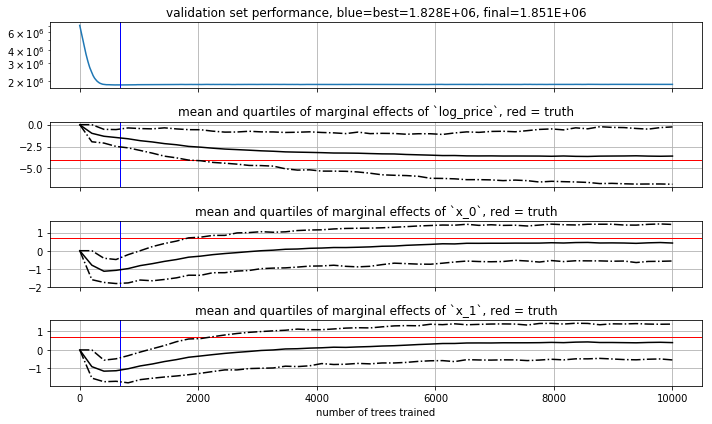

In [16]:
%%time
# print some marginal effects implied by the model
marginal_fx = model.marginal_effect_plots(df_test, plot=False)
display(marginal_fx.groupby('feature name').describe().drop(('marginal effect', 'count'), axis=1))
# and plot it
plot_performance_and_implied_margin_effects_vs_iteration(model, df_test, metric_name='grouped sse', num_grid_pts=50)

In [17]:
assert False

AssertionError: 

# II. try quantiles

In [ ]:
# initialize a nonparametric IV model that estimates quantiles in the first stage and uses a linear
#  specification in the second stage
npiv_estimate_stage1_linear_stage2 = NonparametricIV(df=df_train,
                                                     exog_x_cols=ivsim.exog_x_cols, 
                                                     instrument_cols = ['instrument'],
                                                     endog_x_col=ivsim.endog_x_col,
                                                     y_col=ivsim.y_col,
                                                     id_col='id')

In [ ]:
# train the stage1 models for the model that requires training
npiv_estimate_stage1_linear_stage2.train_stage1()

In [ ]:
# compare the predicted vs true quantiles
qtl_comp_df = pd.concat([
                            npiv_estimate_stage1_linear_stage2.predict_stage1(df_test, prefix='predicted_qtl'),
                            npiv_true_stage1_linear_stage2.predict_stage1(df_test, prefix='true_qtl')
                        ], axis=1)
# plot
plot_df = qtl_comp_df.sample(1000)
alphas = npiv_estimate_stage1_linear_stage2.stage1_params.keys()
ncols=4
nrows = int(np.ceil(len(alphas)/ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2*ncols, 2*nrows), 
                         sharex=True, sharey=True)
for i,alpha in enumerate(alphas):
    ax = axes[i//ncols][i%ncols]
    true_col = 'true_qtl_{:.3f}'.format(alpha)
    pred_col = 'predicted_qtl_{:.3f}'.format(alpha)
    tmp_df = plot_df[[true_col, pred_col]].rename(columns={true_col:'true', pred_col:'predicted'})
    tmp_df.plot(x='true', y = 'predicted', ax=ax, kind='scatter',
                 alpha=.3, s=3, title="{:.3f}-quantile".format(alpha), grid=True)
    # also plot the 45-degree line
    min45, max45 = tmp_df['true'].min(), tmp_df['true'].max()
    ax.plot([min45, max45], [min45, max45], color='red', alpha=.5)
plt.suptitle("comparison of predicted vs true quantiles, with  45-degree line in red")
plt.tight_layout()
plt.subplots_adjust(top=0.9)

In [ ]:
# ok, quantiles look fine.

### 2. stage2 : nonparametric IV

In [ ]:
# and also for when we predict quantiles
npiv_estimate_stage1_linear_stage2.train_stage2()

# print some marginal effects
wrapped_gbm2 = model_wrapper.ModelWrapper(npiv_estimate_stage1_linear_stage2.stage2_model)
marginal_fx = wrapped_gbm2.marginal_effect_plots(df_test, plot=False)
display(marginal_fx.groupby('feature name').describe().transpose())

In [ ]:
ivsim.log_sales_coefs

In [ ]:
assert False

In [ ]:
assert False

In [ ]:
npiv_estimate_stage1_linear_stage2.stage2_data['_qtl_'].describe()

In [ ]:
npiv_estimate_stage1_linear_stage2.stage2_data['_qtl_'].shape

In [ ]:
npiv_estimate_stage1_linear_stage2.stage2_data.head()

In [ ]:
npiv_estimate_stage1_linear_stage2.stage1_qtls

In [ ]:
assert False

In [ ]:
df.head()

In [ ]:
df['log_price'].iloc[:10]

In [ ]:
np.repeat('jacob', 3)

In [ ]:
np.concatenate([np.repeat('jacob', 3), np.repeat('haitao', 4)])

In [ ]:
gbm = npiv_model.stage1_models[.05]

In [ ]:
npiv_model.stage1_params

In [ ]:
npiv_model.stage1_models[.05].eval_results['val']['quantile']

In [ ]:
df.columns